In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# from sklearn.feature_selection import RFECV
from yellowbrick.model_selection import RFECV

from sklearn.feature_selection import RFE
import os
import argparse
from tqdm import tqdm
import pickle
import time
import numpy as np
import pandas as pd

def loadPickle(file_path: str) -> pickle:
    with open(file_path, "rb") as f:
        pk = pickle.load(f)
    return pk

def createCorpusDataset(benignPath: str, malwarePath: str) -> list and list:
    opcode_corpus = []
    label = []
    for file in tqdm(os.listdir(benignPath), desc="Benign"):
        opcode_corpus.append(" ".join(loadPickle(os.path.join(benignPath, file))))
        label.append(0)

    for file in tqdm(os.listdir(malwarePath), desc="Malware"):
        opcode_corpus.append(" ".join(loadPickle(os.path.join(malwarePath, file))))
        label.append(1)
    return opcode_corpus, label

def TFIDFvec(X: list, ng_min: int, ng_max: int) -> np.array:
    vectorizer = TfidfVectorizer(ngram_range = (ng_min, ng_max))
    return vectorizer.fit_transform(X)

def Countvec(X: list, ng_min: int, ng_max: int) -> np.array:
    vectorizer = CountVectorizer(ngram_range = (ng_min, ng_max))
    return vectorizer.fit_transform(X)

def Recursive_Feature_Elimination(clf, X_train: pd.DataFrame, y_train: pd.DataFrame):
    
    # train
    print("Training...")
    start = time.time()
    # clf.fit(X_train, y_train)
    # RFE
    # rfe = RFE(clf, step=0.01)
    # RFCVE
    rfe = RFECV(clf, step=0.01, cv=3, n_jobs=-1)
    rfe.fit(X_train, y_train)
    print("n_features_", rfe.n_features_)
    stop = time.time()
    print(f"Training time: {stop - start} s")
    return rfe

# def get_parser():
#     parser = argparse.ArgumentParser(description = "N-gram RFE")
#     parser.add_argument("-b", "--benign", type = str, help = "Enter source path for benign")
#     parser.add_argument("-m", "--malware", type = str, help = "Enter source path for malware")
#     parser.add_argument("-mth", "--method", type = str, help = "Enter method")
#     return parser

# main ========

benign = "../NICT/DataSet/Toyset/OpcodeSequence_retdec/benign_UFwR"
malware = "../NICT/DataSet/Toyset/OpcodeSequence_retdec/malware_UFwR"
mth = "rf"

# parser = get_parser()
# args = parser.parse_args()

X, y = createCorpusDataset(benign, malware)

# vectorize
print("Vectorizing...")
start = time.time()
# X = TFIDFvec(X, 1, 2)
X = Countvec(X, 1, 2)
end = time.time()
difference = end-start
print("X shape:", X.shape)
print("Vectorize time: ", difference)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

print("total_set shape :", X.shape)
print("yLabel shape :", len(y))
print()
print("train_set shape :", X_train.shape)
print("train_label shape :", len(y_train))
print()
print("test_set shape :", X_test.shape)
print("test_label shape :", len(y_test))
print()

# select method
method = mth
if method == "rf":
    clf = RandomForestClassifier(max_depth = 5, random_state = 42)
elif method == "knn":
    clf = KNeighborsClassifier(n_neighbors=3)
elif method == "svm":
    clf = SVC(kernel="linear")
elif method == "mlp":
    clf = MLPClassifier(random_state=1, max_iter=300)
elif method == "lr":
    clf = LogisticRegression(random_state=0)
elif method == "ld":
    clf = LinearDiscriminantAnalysis()
elif method == "ls":
    clf = Lasso(alpha=0.1)

model = Recursive_Feature_Elimination(clf, X_train, y_train)

model.show()

ACC = model.score(X_test, y_test)
print("Accuracy:", ACC)
print()

predict = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
FNR = fn/(tn+fn)
FPR = fp/(tn+fp)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
F1 = 2*(Precision*Recall)/(Precision+Recall)
TPR = tp/(tp+fn)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, predict, pos_label=2)
# AUC = metrics.auc(fpr, tpr)

print("漏報率(FNR):", FNR)
print("誤報率(FPR):", FPR)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1:", F1)
# print("AUC:", AUC)
print()



Malware: 100%|██████████| 2269/2269 [00:24<00:00, 91.15it/s] 


Vectorizing...
X shape: (3810, 207595)
Vectorize time:  231.48745393753052
total_set shape : (3810, 207595)
yLabel shape : 3810

train_set shape : (3048, 207595)
train_label shape : 3048

test_set shape : (762, 207595)
test_label shape : 762

Training...


Malware: 100%|██████████| 2269/2269 [00:16<00:00, 134.56it/s]


Vectorizing...
X shape: (3810, 41421)
Vectorize time:  184.6980540752411
total_set shape : (3810, 41421)
yLabel shape : 3810

train_set shape : (3048, 41421)
train_label shape : 3048

test_set shape : (762, 41421)
test_label shape : 762

Training...
n_features_ 24853
Training time: 303.9115653038025 s


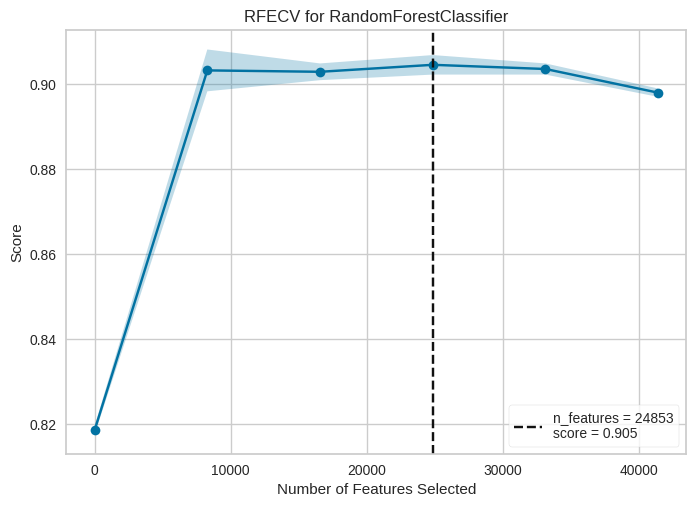

Accuracy: 0.9081364829396326

漏報率(FNR): 0.10574018126888217
誤報率(FPR): 0.10574018126888217
Precision: 0.9187935034802784
Recall: 0.9187935034802784
F1: 0.9187935034802784



In [18]:
def Recursive_Feature_Elimination(clf, X_train: pd.DataFrame, y_train: pd.DataFrame):
    
    # train
    print("Training...")
    start = time.time()
    # clf.fit(X_train, y_train)
    # RFE
    # rfe = RFE(clf, step=0.01)
    # RFCVE
    rfe = RFECV(clf, step=0.2, cv=2, n_jobs=-1)
    rfe.fit(X_train, y_train)
    print("n_features_", rfe.n_features_)
    stop = time.time()
    print(f"Training time: {stop - start} s")
    return rfe

# main ========

benign = "../NICT/DataSet/Toyset/OpcodeSequence_retdec/benign_garbage_removed"
malware = "../NICT/DataSet/Toyset/OpcodeSequence_retdec/malware_garbage_removed"
mth = "rf"

# parser = get_parser()
# args = parser.parse_args()

X, y = createCorpusDataset(benign, malware)

# vectorize
print("Vectorizing...")
start = time.time()
# X = TFIDFvec(X, 1, 2)
X = Countvec(X, 1, 2)
end = time.time()
difference = end-start
print("X shape:", X.shape)
print("Vectorize time: ", difference)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

print("total_set shape :", X.shape)
print("yLabel shape :", len(y))
print()
print("train_set shape :", X_train.shape)
print("train_label shape :", len(y_train))
print()
print("test_set shape :", X_test.shape)
print("test_label shape :", len(y_test))
print()

# select method
method = mth
if method == "rf":
    clf = RandomForestClassifier(max_depth = 500, random_state = 42)
elif method == "knn":
    clf = KNeighborsClassifier(n_neighbors=3)
elif method == "svm":
    clf = SVC(kernel="linear")
elif method == "mlp":
    clf = MLPClassifier(random_state=1, max_iter=300)
elif method == "lr":
    clf = LogisticRegression(random_state=0)
elif method == "ld":
    clf = LinearDiscriminantAnalysis()
elif method == "ls":
    clf = Lasso(alpha=0.1)

model = Recursive_Feature_Elimination(clf, X_train, y_train)

model.show()

ACC = model.score(X_test, y_test)
print("Accuracy:", ACC)
print()

predict = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
FNR = fn/(tn+fn)
FPR = fp/(tn+fp)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
F1 = 2*(Precision*Recall)/(Precision+Recall)
TPR = tp/(tp+fn)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, predict, pos_label=2)
# AUC = metrics.auc(fpr, tpr)

print("漏報率(FNR):", FNR)
print("誤報率(FPR):", FPR)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1:", F1)
# print("AUC:", AUC)
print()